# Introduction

**The aim of this jupyter notebook is to test reinforcement learning with value function approximation, when applying to construct a single stock strategy.** 

We shall focus on a linear function approximation of the Q function. Recall that the Q function takes the form of $Q(s,a)$, where the first argument $s$ represents an element in the state space $S$, and $a$ represents an potential action in the action space $A$. Intuitively, $Q(s,a)$ can be understand as the maximum expected reward if we start from the state $s$, taking action $a$ at the first step, then follows the optimal strategy thereafter. 

If the cardinality of $S$ and $A$ is small, we can directly apply Q learning to approximately compute the state action value function $Q(s,a)$. However, this approach has unaffordable computational complexity when the dimension of $S$ is high, which motivates us to apply value function approximation to achieve dimension reduction.

In the meeting on May 30th 2020, we discussed how to employ a linear function to approximate $Q(s,a)$. Specifically, using a parametrization by a vector $w$ and using a vector $x(s,a)$ to encode the tuple (s,a), we will approximate the Q-function by 
$$Q(s,a;w) = x(s,a)^{\top}w.$$

Thus, the problem of fitting a Q-function $Q(s,a)$ boils down to finding the best vector $w$. We will solve this problem by stochastic gradient descent on $w$. Specifically, we will use the following parameter update rule for Q-learning with linear function approximation:
$$
	\Delta w = \alpha (
	r_j + \gamma \max_{a_{j+1}} x(s_{j+1},a_{j+1})^{\top}w 
	-x(s_j,a_{j})^{\top}w)\cdot
	x(s_j,a_{j}). 
$$
Please check the slides on May 30th 2020 for how to derive the above formula.

**We will construct the state space S and the action space A in the following way:**

$S$ is contructed using the stock information as well as the sectional index momentum. 

$A = \{0,1\}$, representing {Zero Position, Full Position}.

# Load Data and Data Preprocess

In [119]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
from single_stock_pi import SingleStockPI

In [20]:
pro = tushare.pro_api('558af0c6fe4be3945ce1b68021e04d897fa78db639a3f354f2d4e655')
ts_code_list = pro.stock_basic(exchange='', list_status='L', fields='ts_code')['ts_code'][:100]
start_date = '20100101'
end_date = '20200101'
index_list = list(range(26,27)) + list(range(51,67))
index_ts_code_basic = pro.index_basic(market='SZSE').loc[index_list]
index_ts_code_list = index_ts_code_basic['ts_code']

def download_stock_data(ts_code_list):
    for ts_code in ts_code_list:    
        df = tushare.pro_bar(ts_code=ts_code, adj='qfq', start_date=start_date, end_date=end_date)
        df.to_csv('./data/' + ts_code, mode = 'w')
    print("done")
    
def download_index_data(index_ts_code_list):
    for ts_code in index_ts_code_basic:
        df = pro.index_daily(ts_code=ts_code, start_date=start_date, end_date=end_date)
        df.to_csv('./data/' + ts_code, mode = 'w')
    print("done")

def download_stock_fundamental_data(ts_code_list):
    for ts_code in ts_code_list:    
        df = pro.daily_basic(ts_code=ts_code, start_date=start_date, end_date=end_date, 
                             fields='ts_code,trade_date,turnover_rate,volume_ratio,pe,pb,dv_ratio,total_mv')
        df.to_csv('./data/' + ts_code + '_fundamental', mode = 'w')
    print("done")
    
def load_data(ts_code):
    filepath = './data/' + ts_code
    df = pd.read_csv(filepath)
    return df

Here we introduce the index data provided by ``Shenzheng Stock Exchange`` as addition features in this problem 

In [21]:
# Here's the overview of the index list
index_ts_code_basic

,ts_code,name,market,publisher,category,base_date,base_point,list_date
26,399106.SZ,深证综指,SZSE,深交所,综合指数,19910403,100.0,19910404
51,399231.SZ,农林指数,SZSE,深交所,综合指数,19910403,100.0,20130304
52,399232.SZ,采矿指数,SZSE,深交所,综合指数,19910403,100.0,20130304
53,399233.SZ,制造指数,SZSE,深交所,综合指数,19910403,100.0,20130304
54,399234.SZ,水电指数,SZSE,深交所,综合指数,19910403,100.0,20130304
55,399235.SZ,建筑指数,SZSE,深交所,综合指数,19910403,100.0,20130304
56,399236.SZ,批零指数,SZSE,深交所,综合指数,19910403,100.0,20130304
57,399237.SZ,运输指数,SZSE,深交所,综合指数,19910403,100.0,20130304
58,399238.SZ,餐饮指数,SZSE,深交所,综合指数,19910403,100.0,20130304
59,399239.SZ,IT指数,SZSE,深交所,综合指数,19910403,100.0,20130304


In [22]:
# Take a look at a single index table
load_data('399106.SZ').head()

,Unnamed: 0,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,0,399106.SZ,20191231,1722.9450,1712.5224,1722.9450,1711.0751,1713.5075,9.4375,0.5508,282427717.0,305890410.3
1,1,399106.SZ,20191230,1713.5075,1691.6528,1713.5075,1676.2285,1697.9136,15.5939,0.9184,322844925.0,343640782.7
2,2,399106.SZ,20191227,1697.9136,1712.2009,1720.8037,1696.8648,1709.4504,-11.5368,-0.6749,351676420.0,373901862.6
3,3,399106.SZ,20191226,1709.4504,1697.7556,1709.4504,1696.0327,1697.2079,12.2425,0.7213,292929051.0,308016593.9
4,4,399106.SZ,20191225,1697.2079,1689.1273,1700.9571,1687.6762,1690.7352,6.4727,0.3828,290734473.0,313586440.0


In [23]:
# Summerize the one day index change from previous 
index_table = None
for ts_code in index_ts_code_basic['ts_code']:
    df = load_data(ts_code)[['trade_date','pct_chg']].rename(columns={"pct_chg": "{}_pct_chg".format(ts_code)})
    if index_table is None:
        index_table = df.copy()
        index_table.set_index('trade_date')
    else:
        index_table = index_table.join(df.set_index('trade_date'), how = 'outer', on = 'trade_date')
index_table = index_table.set_index('trade_date').sort_index()
index_table.head()

,399106.SZ_pct_chg,399231.SZ_pct_chg,399232.SZ_pct_chg,399233.SZ_pct_chg,399234.SZ_pct_chg,399235.SZ_pct_chg,399236.SZ_pct_chg,399237.SZ_pct_chg,399238.SZ_pct_chg,399239.SZ_pct_chg,399240.SZ_pct_chg,399241.SZ_pct_chg,399242.SZ_pct_chg,399243.SZ_pct_chg,399244.SZ_pct_chg,399248.SZ_pct_chg,399249.SZ_pct_chg
trade_date,,,,,,,,,,,,,,,,,
20100104,-0.2146,1.9793,-1.2857,0.0758,-0.0896,-0.1406,0.4011,-0.0148,-0.2146,1.4836,-2.5054,-2.1477,-0.2146,-0.2146,-0.2146,-0.1481,-0.3581
20100105,0.5611,1.8702,3.4542,0.6469,0.6350,0.3175,-0.1109,0.6566,0.5611,2.0712,1.9988,-2.7579,0.5611,0.5611,0.5611,2.1311,-0.1667
20100106,-0.1863,-1.6034,0.3286,-0.1482,0.4030,0.8248,-0.9550,-0.4754,-0.1863,-0.6532,-0.8471,0.2155,-0.1863,-0.1863,-0.1863,-0.3051,0.4604
20100107,-1.9329,-2.2314,-2.2486,-2.0078,-2.1045,-2.1243,-3.0206,-1.2129,-1.9329,-2.7886,-1.7046,-0.5001,-1.9329,-1.9329,-1.9329,-2.4117,-0.1162
20100108,0.6673,1.0760,-1.4006,0.4797,1.2663,0.8740,1.0697,1.3592,0.6673,1.3985,1.5368,1.3662,0.6673,0.6673,0.6673,1.3220,1.3178


In [24]:
# load data
# take one stock data as an example
ts_code = '000037.SZ'

stock_full_df = load_data(ts_code)
stock_full_df = stock_full_df.set_index('trade_date').sort_index()
stock_full_df['1_day_pct_chg'] = stock_full_df['close'].pct_change(1)
stock_full_df['5_day_pct_chg'] = stock_full_df['close'].pct_change(5)
stock_full_df = stock_full_df[['ts_code', 'close', '1_day_pct_chg', '5_day_pct_chg']]
#stock_full_df.join(), how = 'left', on = 'trade_date')
stock_full_df.head(10)
#features = df[{"1_day_pct_chg", "5_day_pct_chg"}].to_numpy()[5:]
#features.shape

,ts_code,close,1_day_pct_chg,5_day_pct_chg
trade_date,,,,
20100104,000037.SZ,7.18,NaN,NaN
20100105,000037.SZ,7.29,0.015320,NaN
20100106,000037.SZ,7.33,0.005487,NaN
20100107,000037.SZ,7.13,-0.027285,NaN
20100108,000037.SZ,7.18,0.007013,NaN
20100111,000037.SZ,7.15,-0.004178,-0.004178
20100112,000037.SZ,7.33,0.025175,0.005487
20100113,000037.SZ,7.22,-0.015007,-0.015007
20100114,000037.SZ,7.54,0.044321,0.057504


Please check the explaination of column [Here](https://tushare.pro/document/2?doc_id=32).
- turn over rate: 换手率（%）
- volume_ratio： 量比
- pe：市盈率（总市值/净利润， 亏损的PE为空）
- pb: 市净率（总市值/净资产）

In [25]:
stock_modelstate_df = load_data(ts_code+'_fundamental').set_index('trade_date').sort_index()
stock_modelstate_df = stock_modelstate_df[['turnover_rate', 'volume_ratio', 'pe', 'pb']]
stock_modelstate_df['is_pe_null'] = stock_modelstate_df['pe'].isnull().astype(np.int)
# Replace the null value of 'pe' by 0
stock_modelstate_df.fillna({'pe':0}, inplace = True)
stock_modelstate_df.head()

,turnover_rate,volume_ratio,pe,pb,is_pe_null
trade_date,,,,,
20100104,1.1272,0.87,402.0687,2.2296,0
20100105,1.6057,1.19,408.2285,2.2638,0
20100106,1.7424,1.21,410.4685,2.2762,0
20100107,1.1660,0.81,399.2688,2.2141,0
20100108,0.8947,0.64,402.0687,2.2296,0


In [26]:
stock_full_df = stock_full_df.join(stock_modelstate_df, how = 'left', on = 'trade_date')
stock_full_df = stock_full_df.join(index_table, how = 'left', on = 'trade_date')
stock_full_df.head(10)

,ts_code,close,1_day_pct_chg,5_day_pct_chg,turnover_rate,volume_ratio,pe,pb,is_pe_null,399106.SZ_pct_chg,...,399237.SZ_pct_chg,399238.SZ_pct_chg,399239.SZ_pct_chg,399240.SZ_pct_chg,399241.SZ_pct_chg,399242.SZ_pct_chg,399243.SZ_pct_chg,399244.SZ_pct_chg,399248.SZ_pct_chg,399249.SZ_pct_chg
trade_date,,,,,,,,,,,,,,,,,,,,,
20100104,000037.SZ,7.18,NaN,NaN,1.1272,0.87,402.0687,2.2296,0,-0.2146,...,-0.0148,-0.2146,1.4836,-2.5054,-2.1477,-0.2146,-0.2146,-0.2146,-0.1481,-0.3581
20100105,000037.SZ,7.29,0.015320,NaN,1.6057,1.19,408.2285,2.2638,0,0.5611,...,0.6566,0.5611,2.0712,1.9988,-2.7579,0.5611,0.5611,0.5611,2.1311,-0.1667
20100106,000037.SZ,7.33,0.005487,NaN,1.7424,1.21,410.4685,2.2762,0,-0.1863,...,-0.4754,-0.1863,-0.6532,-0.8471,0.2155,-0.1863,-0.1863,-0.1863,-0.3051,0.4604
20100107,000037.SZ,7.13,-0.027285,NaN,1.1660,0.81,399.2688,2.2141,0,-1.9329,...,-1.2129,-1.9329,-2.7886,-1.7046,-0.5001,-1.9329,-1.9329,-1.9329,-2.4117,-0.1162
20100108,000037.SZ,7.18,0.007013,NaN,0.8947,0.64,402.0687,2.2296,0,0.6673,...,1.3592,0.6673,1.3985,1.5368,1.3662,0.6673,0.6673,0.6673,1.3220,1.3178
20100111,000037.SZ,7.15,-0.004178,-0.004178,0.7743,0.59,400.3887,2.2203,0,0.1759,...,0.7139,0.1758,2.8564,-0.0308,-2.2138,0.1758,0.1758,0.1758,2.0376,-0.0776
20100112,000037.SZ,7.33,0.025175,0.005487,1.3078,1.06,410.4685,2.2762,0,1.9459,...,1.4302,1.9459,3.2996,-0.3092,1.4035,1.9459,1.9459,1.9459,1.1014,1.7846
20100113,000037.SZ,7.22,-0.015007,-0.015007,1.3064,1.11,404.3086,2.2421,0,-1.5968,...,-1.8240,-1.5969,1.7098,-5.8613,-3.4288,-1.5969,-1.5969,-1.5969,3.0487,-2.5092
20100114,000037.SZ,7.54,0.044321,0.057504,2.7348,2.51,422.2281,2.3414,0,2.1259,...,2.0081,2.1260,2.5917,1.0495,0.9076,2.1260,2.1260,2.1260,4.3059,2.0556


In [27]:
stock_full_df['forward_1_day_pct_chg'] = stock_full_df[['1_day_pct_chg']].shift(periods=-1)
stock_full_df = stock_full_df.iloc[5:-1]
stock_full_df.head(10)

,ts_code,close,1_day_pct_chg,5_day_pct_chg,turnover_rate,volume_ratio,pe,pb,is_pe_null,399106.SZ_pct_chg,...,399238.SZ_pct_chg,399239.SZ_pct_chg,399240.SZ_pct_chg,399241.SZ_pct_chg,399242.SZ_pct_chg,399243.SZ_pct_chg,399244.SZ_pct_chg,399248.SZ_pct_chg,399249.SZ_pct_chg,forward_1_day_pct_chg
trade_date,,,,,,,,,,,,,,,,,,,,,
20100111,000037.SZ,7.15,-0.004178,-0.004178,0.7743,0.59,400.3887,2.2203,0,0.1759,...,0.1758,2.8564,-0.0308,-2.2138,0.1758,0.1758,0.1758,2.0376,-0.0776,0.025175
20100112,000037.SZ,7.33,0.025175,0.005487,1.3078,1.06,410.4685,2.2762,0,1.9459,...,1.9459,3.2996,-0.3092,1.4035,1.9459,1.9459,1.9459,1.1014,1.7846,-0.015007
20100113,000037.SZ,7.22,-0.015007,-0.015007,1.3064,1.11,404.3086,2.2421,0,-1.5968,...,-1.5969,1.7098,-5.8613,-3.4288,-1.5969,-1.5969,-1.5969,3.0487,-2.5092,0.044321
20100114,000037.SZ,7.54,0.044321,0.057504,2.7348,2.51,422.2281,2.3414,0,2.1259,...,2.1260,2.5917,1.0495,0.9076,2.1260,2.1260,2.1260,4.3059,2.0556,0.017241
20100118,000037.SZ,7.67,0.017241,0.068245,2.1023,1.50,429.5079,2.3818,0,1.1625,...,1.1625,1.4535,-1.3235,1.4010,1.1625,1.1625,1.1625,0.5137,2.7617,-0.010430
20100119,000037.SZ,7.59,-0.010430,0.061538,1.4381,0.87,425.0280,2.3570,0,-0.3037,...,-0.3037,-1.5400,2.5461,-0.1870,-0.3037,-0.3037,-0.3037,0.5624,-0.2676,-0.022398
20100120,000037.SZ,7.42,-0.022398,0.012278,2.1365,1.20,415.5083,2.3042,0,-3.6747,...,-3.6747,-5.5114,-2.8482,-3.2105,-3.6747,-3.6747,-3.6747,-4.3636,-2.8484,0.024259
20100121,000037.SZ,7.60,0.024259,0.052632,1.6509,0.85,425.5880,2.3601,0,0.2064,...,0.2064,-0.0116,2.7368,1.0100,0.2064,0.2064,0.2064,3.1520,0.5841,-0.043421
20100122,000037.SZ,7.27,-0.043421,-0.035809,1.1777,0.59,407.1085,2.2576,0,-2.7062,...,-2.7062,-2.9631,-0.1533,-1.9241,-2.7062,-2.7062,-2.7062,-2.9702,-2.9868,-0.026135


# Return prediction by Q-learning with linear function approximation

## in-sample feature selection

In [13]:
from statsmodels.api import OLS
in_sample_filter = stock_full_df.index < 20170000 
X = stock_full_df.iloc[:,1:-1]
y = stock_full_df.iloc[:,-1]
normalized_X=(X-X[in_sample_filter].mean())/X[in_sample_filter].std()
OLS_result = OLS(y[in_sample_filter],normalized_X[in_sample_filter]).fit()
feature_cols = X.columns[OLS_result.pvalues < 0.05]
OLS_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     forward_1_day_pct_chg   R-squared (uncentered):                   0.044
Model:                               OLS   Adj. R-squared (uncentered):              0.027
Method:                    Least Squares   F-statistic:                              2.572
Date:                   Wed, 26 Aug 2020   Prob (F-statistic):                    3.53e-05
Time:                           17:50:33   Log-Likelihood:                          2811.8
No. Observations:                   1409   AIC:                                     -5574.
Df Residuals:                       1384   BIC:                                     -5442.
Df Model:                             25                                                  
Covariance Type:               nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
close                -0.0016      0.002     -0.677      0.498      -0.006       0.003
1_day_pct_chg         0.0029      0.001      2.022      0.043    8.52e-05       0.006
5_day_pct_chg         0.0002      0.001      0.181      0.856      -0.002       0.002
turnover_rate        -0.0010      0.002     -0.638      0.523      -0.004       0.002
volume_ratio         -0.0010      0.001     -0.910      0.363      -0.003       0.001
pe                   -0.0001      0.001     -0.114      0.909      -0.002       0.002
pb                    0.0014      0.002      0.723      0.470      -0.002       0.005
is_pe_null           -0.0007      0.001     -0.550      0.582      -0.003       0.002
399106.SZ_pct_chg    -0.0109      0.028     -0.388      0.698      -0.066       0.044
399231.SZ_pct_chg    -0.0023      0.002     -1.196      0.232      -0.006       0.001
399232.SZ_pct_chg    -0.0017      0.002     -0.795      0.427      -0.006       0.003
399233.SZ_pct_chg     0.0160      0.018      0.881      0.379      -0.020       0.052
399234.SZ_pct_chg    -0.0027      0.003     -1.028      0.304      -0.008       0.002
399235.SZ_pct_chg    -0.0011      0.002     -0.452      0.651      -0.006       0.004
399236.SZ_pct_chg     0.0038      0.003      1.320      0.187      -0.002       0.009
399237.SZ_pct_chg     0.0034      0.002      1.450      0.147      -0.001       0.008
399238.SZ_pct_chg     0.0025      0.002      1.172      0.241      -0.002       0.007
399239.SZ_pct_chg    -0.0002      0.004     -0.055      0.956      -0.008       0.008
399240.SZ_pct_chg     0.0017      0.002      0.709      0.479      -0.003       0.006
399241.SZ_pct_chg     0.0010      0.002      0.416      0.677      -0.004       0.006
399242.SZ_pct_chg    -0.0064      0.002     -2.601      0.009      -0.011      -0.002
399243.SZ_pct_chg     0.0015      0.003      0.534      0.594      -0.004       0.007
399244.SZ_pct_chg     0.0025      0.003      0.918      0.359      -0.003       0.008
399248.SZ_pct_chg    -0.0004      0.002     -0.243      0.808      -0.004       0.003
399249.SZ_pct_chg    -0.0040      0.002     -2.195      0.028      -0.008      -0.000
==============================================================================
Omnibus:                       90.578   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.300
Skew:                           0.332   Prob(JB):                     1.47e-53
Kurtosis:                       4.924   Cond. No.                         142.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of t

Conducted OLS on the short list of features: R^2 is almost same

In [14]:
features = normalized_X.loc[:, feature_cols]
smaller_OLS_result = OLS(y[in_sample_filter], features[in_sample_filter]).fit()
smaller_OLS_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     forward_1_day_pct_chg   R-squared (uncentered):                   0.017
Model:                               OLS   Adj. R-squared (uncentered):              0.015
Method:                    Least Squares   F-statistic:                              8.235
Date:                   Wed, 26 Aug 2020   Prob (F-statistic):                    1.97e-05
Time:                           17:50:34   Log-Likelihood:                          2792.1
No. Observations:                   1409   AIC:                                     -5578.
Df Residuals:                       1406   BIC:                                     -5562.
Df Model:                              3                                                  
Covariance Type:               nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
1_day_pct_chg         0.0036      0.001      3.266      0.001       0.001       0.006
399242.SZ_pct_chg     0.0006      0.001      0.390      0.697      -0.002       0.003
399249.SZ_pct_chg     0.0007      0.002      0.491      0.624      -0.002       0.004
==============================================================================
Omnibus:                       74.088   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.421
Skew:                           0.160   Prob(JB):                     2.78e-52
Kurtosis:                       4.985   Cond. No.                         3.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
def epsilon_greedy(x, epsilon, w):
    # helper function that computes the epsilon-greedy policy
    indicator = np.random.binomial(1, epsilon)
    a_argmax = 1 if x @ w >0 else 0
    a_rand = np.random.randint(2)
    if indicator:
        a = a_rand
    else:
        a = a_argmax    
    return a
    
def Q_learning(features, y, gamma):
    
    w = np.zeros((features.shape[1]))
    
    epsilon, k, alpha = 1, 1, 1
    x_k = features.iloc[0]
    a_k = epsilon_greedy(x_k, epsilon, w)
    r_k = a_k * y.iloc[0]
    pct_returns = np.array([r_k])
    
    while k < features.shape[0]:
        x_kp1 = features.iloc[k]
        a_kp1 = epsilon_greedy(x_kp1, epsilon, w)
        r_kp1 = a_kp1 * y.iloc[k]
        pct_returns = np.append(pct_returns,r_kp1)
        w = w + alpha * (r_k + gamma * max(w@x_kp1, 0) - x_k@w)*x_k
        k = k + 1
        alpha = 1/k
        epsilon = min(1, 1/(0.02*k))
        x_k, a_k, r_k = x_kp1, a_kp1, r_kp1
    return pct_returns

In [16]:
policy_pct_returns = Q_learning(features, y, gamma = 0.95)

In [17]:
policy_log_returns = np.log(1+policy_pct_returns)

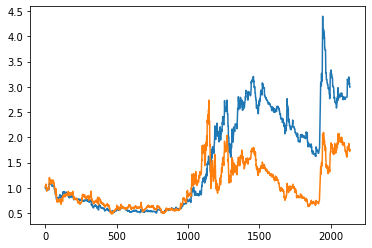

In [18]:
plt.plot(np.cumprod(1+policy_pct_returns))
plt.plot(np.cumprod((1+y).values))

# Multiple Stock Test

In [29]:
ts_code_list

0     000001.SZ
1     000002.SZ
2     000004.SZ
3     000005.SZ
4     000006.SZ
        ...    
95    000488.SZ
96    000498.SZ
97    000501.SZ
98    000502.SZ
99    000503.SZ
Name: ts_code, Length: 100, dtype: object

In [131]:
policy_pct_returns_table = pd.DataFrame()
stock_pct_returns_table = pd.DataFrame()
for ts_code in tqdm.tqdm(ts_code_list):
    stock_full_df = load_data(ts_code)
    stock_full_df = stock_full_df.set_index('trade_date').sort_index()
    stock_full_df['1_day_pct_chg'] = stock_full_df['close'].pct_change(1)
    stock_full_df['5_day_pct_chg'] = stock_full_df['close'].pct_change(5)
    stock_full_df = stock_full_df[['ts_code', 'close', '1_day_pct_chg', '5_day_pct_chg']]
    # load stock model state
    stock_modelstate_df = load_data(ts_code+'_fundamental').set_index('trade_date').sort_index()
    stock_modelstate_df = stock_modelstate_df[['turnover_rate', 'volume_ratio', 'pe', 'pb']]
    stock_modelstate_df['is_pe_null'] = stock_modelstate_df['pe'].isnull().astype(np.int)
    stock_modelstate_df.fillna({'pe':0}, inplace = True)
    stock_full_df = stock_full_df.join(stock_modelstate_df, how = 'left', on = 'trade_date')
    stock_full_df = stock_full_df.join(index_table, how = 'left', on = 'trade_date')
    stock_full_df['forward_1_day_pct_chg'] = stock_full_df[['1_day_pct_chg']].shift(periods=-1)
    stock_full_df = stock_full_df.iloc[5:-1]
    stock_full_df.fillna(0, inplace = True)
    stock_full_df = stock_full_df.set_index(pd.to_datetime(stock_full_df.index, format = '%Y%m%d'))

    X = stock_full_df.iloc[:,1:-1]
    y = stock_full_df.iloc[:,-1]
    normalized_X=(X-X.mean())/X.std()
    normalized_X.fillna(0, inplace = True)
    OLS_result = OLS(y[:'20170101'],normalized_X[:'20170101']).fit()
    feature_cols = X.columns[OLS_result.pvalues < 0.05]
    features = normalized_X.loc[:, feature_cols]
    policy_pct_returns = Q_learning(features, y, gamma = 0.95)
    policy_pct_returns = pd.Series(data=policy_pct_returns, index=y.index)
    stock_pct_returns_table[ts_code] = y
    policy_pct_returns_table[ts_code] = policy_pct_returns

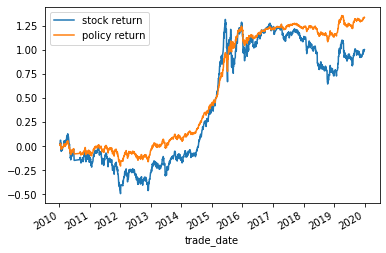

In [141]:
stock_pct_returns_table.mean(axis = 1).cumsum().plot()
policy_pct_returns_table.mean(axis = 1).cumsum().plot()
plt.legend(['stock return', 'policy return'])
plt.show()

In [149]:
stock_sharpe = (stock_pct_returns_table.mean(axis = 1).mean() 
                / stock_pct_returns_table.mean(axis = 1).std()) * np.sqrt(252)
policy_sharpe = (policy_pct_returns_table.mean(axis = 1).mean() 
                 / policy_pct_returns_table.mean(axis = 1).std()) * np.sqrt(252)
print('stock Sharpe = {:.2f}, policy Sharpe = {:.2f}'.format(stock_sharpe, policy_sharpe))

stock Sharpe = 0.37, policy Sharpe = 1.00
